In [44]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import sklearn.preprocessing as pre
from pandas import DataFrame
from pandas import concat
from scipy.stats import linregress as lr
from scipy.signal import find_peaks as find_peaks
from scipy.fftpack import fft, ifft,rfft
from sklearn.decomposition import PCA
from scipy.optimize import curve_fit
import pickle
from sklearn.model_selection import KFold
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.externals import joblib
from sklearn.neural_network import MLPClassifier

patient = 1

# 0. Feature Set Calculation Functions

In [2]:
# Globals
COLUMNS = np.array(['Slope_minmax', 
           'PeakVal1_error', 'PeakVal2_error', 'PeakHt1_error', 'PeakHt2_error', 
           'Min1_window', 'Min2_window', 'Max1_window', 'Max2_window', 'Var1_window', 'Var2_window', 'Mean1_window', 'Mean2_window', 
           'Sig_coef1','Sig_coef2','Sig_coef3','Sig_coef4',
           'Max_fft', 'Min_fft', 'Mean_fft', 'Var_fft'
          ])

In [3]:
def CalcFeatureSet1(cgmNorm_np, cgmSeries_np):
    maxs = np.argmax(cgmNorm_np, axis=1)
    mins = [np.argmin(cgmNorm_np[i, maxs[i]:])+maxs[i] for i in range(len(maxs))]

    slopes = []
    time_diffs = []
    for i in range(len(maxs)):
        slope = (cgmNorm_np[i][maxs[i]]-cgmNorm_np[i][mins[i]])/(cgmSeries_np[maxs[i]]-cgmSeries_np[mins[i]])
        time_diffs.append(cgmSeries_np[maxs[i]]-cgmSeries_np[mins[i]])
        slopes.append(slope)

    slopes = np.nan_to_num(slopes)
    time_diffs = np.nan_to_num(time_diffs)
    reg_window_size = 4
    reg_errors = []
    peak_values = []
    peak_heights = []
    peak_time_diffs = []
    peak_times = []
    for j in range(len(cgmNorm_np)):
        errors = np.array([])
        for i in range(len(cgmNorm_np[j])-reg_window_size):
            times = cgmSeries_np[i:i+reg_window_size-1]
            if np.isnan(times).any():
                errors = np.append(errors, -1)
                continue
            coeffs = np.polyfit(times, cgmNorm_np[j][i:i+reg_window_size-1], 1)
            poly = np.poly1d(coeffs)
            error = poly(cgmSeries_np[i+reg_window_size])-cgmNorm_np[j][i+reg_window_size];
            errors = np.append(errors, error)
        peaks, height_dict = find_peaks(errors, height = 0)
        heights = height_dict['peak_heights']
        sorted_args = heights.argsort()
        peaks = peaks[sorted_args]
        peaks = peaks[-2:]
        heights = heights[sorted_args]
        heights = heights[-2:]
        values = cgmNorm_np[j][peaks+reg_window_size-1]
        times1 = cgmSeries_np[peaks+reg_window_size]
        times2 = cgmSeries_np[peaks+reg_window_size-1]
        reg_errors.append(errors)
        while(len(values) < 2):
            values = np.append(values, 0)
            heights = np.append(heights, 0)
            times1 = np.append(times, 0)
            times2 = np.append(times2, 0)
        peak_values.append(values)
        peak_heights.append(heights)
        peak_time_diffs.append(times1)
        peak_times.append(times2)
    reg_errors = np.array(reg_errors)
    matrix = []
    for i in range(0, len(cgmNorm_np)):
        matrix_row = np.array([])
        matrix_row = np.append(matrix_row, slopes[i])
#         matrix_row = np.append(matrix_row, time_diffs[i])
        matrix_row = np.append(matrix_row, peak_values[i])
        matrix_row = np.append(matrix_row, peak_heights[i])
#         matrix_row = np.append(matrix_row, peak_times[i])
        matrix.append(matrix_row)
    matrix = np.array(matrix)
    return matrix

In [4]:
def CalcFeatureSet2(cgmNorm_np, cgmSeries_np):
    window_mins = []
    window_maxs = []
    window_means = []
    window_vars = []
    for i in range(0, len(cgmNorm_np)):
        window_input = DataFrame(cgmNorm_np[i][::-1])
        width=5
        shifted=window_input.shift(width - 1)
        window=shifted.rolling(window=width)
        dataframe=concat([window.var(), window.min(),  window.mean(), window.max() ], axis=1)
        dataframe.columns = ['var', 'min', 'mean', 'max']
        window_features = dataframe.nlargest(2,'var')
        window_values = window_features.values
        window_mins.append([window_values[0][1], window_values[1][1]])
        window_maxs.append([window_values[0][3], window_values[1][3]])
        window_vars.append([window_values[0][0], window_values[1][0]])
        window_means.append([window_values[0][2], window_values[1][2]])
    
    matrix = []
    for i in range(0, len(cgmNorm_np)):
        matrix_row = np.array([])
        matrix_row = np.append(matrix_row, window_mins[i])
        matrix_row = np.append(matrix_row, window_maxs[i])
        matrix_row = np.append(matrix_row, window_vars[i])
        matrix_row = np.append(matrix_row, window_means[i])
        matrix.append(matrix_row)
    matrix = np.array(matrix)
    return matrix

In [5]:
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return (y)

def CalcFeatureSet3(cgmNorm_np, cgmSeries_np):
    n_series = []
    n_datenum = []
    sig1 = []
    sig2 = []
    sig3 = []
    sig4 = []
    for i in range(0, len(cgmNorm_np)):
        idx = np.isfinite(cgmSeries_np) & np.isfinite(cgmNorm_np[i])
        n_series.append(cgmNorm_np[i][idx])  
        n_datenum.append(cgmSeries_np[idx])
    for i in range(0,len(cgmNorm_np)):
        if(len(n_series[i]) !=0 ):
            try:
                p0 = [max(n_series[i]), np.median(n_datenum[i]),250,min(n_series[i])] 
                popt, pcov = curve_fit(sigmoid, n_datenum[i], n_series[i],p0,method='trf')
            except: 
                popt=[0,0,0,0]

            sig1.append(popt[0])
            sig2.append(popt[1])
            sig3.append(popt[2])
            sig4.append(popt[3])
    
    matrix = []
    for i in range(0, len(cgmNorm_np)):
        matrix_row = np.array([])
        matrix_row = np.append(matrix_row, sig1[i])
        matrix_row = np.append(matrix_row, sig2[i])
        matrix_row = np.append(matrix_row, sig3[i])
        matrix_row = np.append(matrix_row, sig4[i])
        matrix.append(matrix_row)
    matrix = np.array(matrix)
    return matrix

In [6]:
def CalcFeatureSet4(cgmNorm_np, cgmSeries_np):
    Feature_vector=[]
    for i in range(0, len(cgmNorm_np)):
    #FFT
        fastfouriertransform=rfft(cgmNorm_np[i])
        fft_max=np.nanmax(fastfouriertransform)
        s=np.where(fastfouriertransform == fft_max)
        fft_min=np.nanmin(fastfouriertransform)
        s=np.where(fastfouriertransform == fft_min)
        fft_mean=np.nanmean(fastfouriertransform)
        fft_variance=np.nanvar(fastfouriertransform)
        Feature_vector.append(np.array([fft_max,fft_min,fft_mean,fft_variance]))
    matrix = np.array(Feature_vector)
    return matrix

In [7]:
def MergedFeatures(cgmNorm_np, cgmSeries_np):
    feature_set_1 = CalcFeatureSet1(cgmNorm_np, cgmSeries_np)
    feature_set_2 = CalcFeatureSet2(cgmNorm_np, cgmSeries_np)
    feature_set_3 = CalcFeatureSet3(cgmNorm_np, cgmSeries_np)
    feature_set_4 = CalcFeatureSet4(cgmNorm_np, cgmSeries_np)
    features = np.concatenate((feature_set_1, feature_set_2), axis=1)
    features = np.concatenate((features, feature_set_3), axis=1)
    features = np.concatenate((features, feature_set_4), axis=1)
    features = np.nan_to_num(features)
    return features

In [8]:
def GenerateDF(features, columns):
    feature_df = pd.DataFrame(features, columns=columns)
    return feature_df

In [9]:
def NormalizeDF(feature_df, columns, max_scale):
    for i in columns:
        feature_df[i] = feature_df[i]/max_scale[i]
    return feature_df
#     means = feature_df.mean(axis=0)
#     large_means = np.argwhere(means>1).flatten()
#     small_means = np.argwhere(means<-1).flatten()
#     for i in large_means:
#         base = int(np.log10(means[i]))+1
#         if base > 1:
#             feature_df[columns[i]] = np.nan_to_num(np.log10(feature_df[columns[i]].replace(0, np.nan)))/base
#     for i in small_means:
#         base = int(np.log10(np.abs(means[i])))+1
#         if base > 1:
#             feature_df[columns[i]] = np.sign(feature_df[columns[i]])*np.nan_to_num(np.log10(np.abs(feature_df[columns[i]].replace(0, np.nan))))/base
# #     print(large_means)
#     return feature_df

# 1. Calculating Feature Sets

## 1.1 Reading Meal Data

In [10]:
file_no = [1, 2, 3, 4, 5]

In [11]:
cgmData = pd.read_csv("ComparisonData/mealData" + str(1) + '.csv', names=list(range(50)))
for i in file_no[1:]:
    cgm = pd.read_csv("ComparisonData/mealData" + str(i) + '.csv', names=list(range(50)))
    cgmData = cgmData.append(cgm)
cgmData = cgmData.dropna(axis='columns', how='all')
cgmData = cgmData.mask(cgmData.eq(-1)).ffill(axis=1)

zero_entries = cgmData.isna().any(axis=1)
cgmData = cgmData[zero_entries == False]

cgmValues_np = cgmData.values
cgmNorm_np = cgmValues_np/400.0

length = len(cgmNorm_np[0])
cgmSeries_np = [0.0833*(length-i-1) for i in range(0, length)]
cgmSeries_np = np.array(cgmSeries_np)
features = MergedFeatures(cgmNorm_np, cgmSeries_np)
features_df = GenerateDF(features, COLUMNS)
max_scale = features_df.abs().max(axis=0)
max_scale.to_pickle('DataScale.pkl')
normal_df = NormalizeDF(features_df, COLUMNS, max_scale)
display(normal_df)
normal_df.to_csv('MealFeatures.csv', index=False)

cgmData = pd.read_csv("ComparisonData/Nomeal" + str(1) + '.csv', names=list(range(50)))
for i in file_no[1:]:
    cgm = pd.read_csv("ComparisonData/Nomeal" + str(i) + '.csv', names=list(range(50)))
    cgmData = cgmData.append(cgm)
cgmData = cgmData.dropna(axis='columns', how='all')
cgmData = cgmData.mask(cgmData.eq(-1)).ffill(axis=1)

zero_entries = cgmData.isna().any(axis=1)
cgmData = cgmData[zero_entries == False]

cgmValues_np = cgmData.values
cgmNorm_np = cgmValues_np/400.0

length = len(cgmNorm_np[0])
cgmSeries_np = [0.0833*(length-i-1) for i in range(0, length)]
cgmSeries_np = np.array(cgmSeries_np)
features = MergedFeatures(cgmNorm_np, cgmSeries_np)
features_df = GenerateDF(features, COLUMNS)
normal_df = NormalizeDF(features_df, COLUMNS, max_scale)
display(normal_df)
normal_df.to_csv('NoMealFeatures.csv', index = False)

C:\Users\vedan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


,Slope_minmax,PeakVal1_error,PeakVal2_error,PeakHt1_error,PeakHt2_error,Min1_window,Min2_window,Max1_window,Max2_window,Var1_window,...,Mean1_window,Mean2_window,Sig_coef1,Sig_coef2,Sig_coef3,Sig_coef4,Max_fft,Min_fft,Mean_fft,Var_fft
0,0.223958,0.786632,0.6925,3.791946e-01,4.189944e-01,0.672222,0.663889,0.7300,0.726817,0.151981,...,0.702505,0.684127,-0.000170,0.153694,0.005126,0.001134,0.704449,-0.305146,0.634014,0.501904
1,0.181818,0.370180,0.5000,1.979866e-01,2.420857e-01,0.419444,0.391667,0.4900,0.466165,0.091495,...,0.451461,0.428571,-0.000300,0.141317,0.499994,0.000674,0.377450,-0.368154,0.351433,0.148848
2,0.193182,0.519280,0.4700,3.087248e-01,2.756052e-01,0.250000,0.230556,0.3975,0.358396,0.190450,...,0.328288,0.292593,0.000517,0.099185,0.003870,0.000328,0.376598,-0.543992,0.284399,0.155170
3,0.245536,0.383033,0.5350,3.053691e-01,1.750466e-01,0.341667,0.327778,0.4225,0.403509,0.098461,...,0.382568,0.360847,0.000286,0.144382,0.124742,0.000593,0.433015,-0.226763,0.418339,0.191966
4,0.100216,0.336761,0.4000,1.711409e-01,1.005587e-01,0.311111,0.297222,0.3650,0.348371,0.049465,...,0.338205,0.322222,0.000332,0.077384,0.002012,0.000383,0.374979,-0.273501,0.318875,0.145182
5,0.181250,0.483290,0.4050,4.127517e-01,3.538175e-01,0.394444,0.372222,0.4625,0.456140,0.096044,...,0.427975,0.406878,0.000008,0.094918,0.187497,0.000679,0.439066,-0.064095,0.437468,0.194212
6,0.212500,0.249357,0.4850,1.543624e-01,1.527002e-01,0.313889,0.363889,0.4475,0.486216,0.174880,...,0.382046,0.430159,0.000687,0.104814,0.002248,0.000365,0.442816,-0.632198,0.319197,0.215531
7,0.191810,0.622108,0.4000,2.718121e-01,1.731844e-01,0.422222,0.444444,0.5000,0.526316,0.107533,...,0.461378,0.498413,0.000751,0.139094,0.001464,0.000570,0.518323,-0.430815,0.441206,0.282494
8,0.265625,0.329049,0.3100,1.107383e-01,2.867784e-01,0.261111,0.255556,0.3525,0.338346,0.109092,...,0.311065,0.289418,0.000146,0.068885,0.018764,0.000390,0.311829,-0.117482,0.282665,0.098783
9,0.216346,0.370180,0.4825,2.583893e-01,1.508380e-01,0.327778,0.352778,0.4275,0.456140,0.128847,...,0.376305,0.415344,0.000326,0.099225,0.005198,0.000487,0.417249,-0.362590,0.352390,0.180399


,Slope_minmax,PeakVal1_error,PeakVal2_error,PeakHt1_error,PeakHt2_error,Min1_window,Min2_window,Max1_window,Max2_window,Var1_window,...,Mean1_window,Mean2_window,Sig_coef1,Sig_coef2,Sig_coef3,Sig_coef4,Max_fft,Min_fft,Mean_fft,Var_fft
0,0.144231,0.501285,0.3575,0.154362,0.093110,0.447222,0.461111,0.4725,0.488722,0.034883,...,0.456159,0.480423,0.000595,0.106044,0.001025,0.000358,0.390830,-0.348937,0.337304,0.165106
1,0.043750,0.228792,0.2575,0.204698,0.232775,0.250000,0.250000,0.2625,0.263158,0.013334,...,0.251566,0.261905,0.000100,0.055730,0.000748,0.000301,0.227373,-0.045013,0.223039,0.053624
2,0.035511,0.221080,0.2350,0.144295,0.093110,0.205556,0.211111,0.2150,0.218045,0.006290,...,0.208246,0.217989,0.000156,0.021060,0.000920,0.000226,0.216550,-0.055635,0.207839,0.048761
3,0.062500,0.275064,0.2350,0.137584,0.229050,0.277778,0.305556,0.3550,0.370927,0.072390,...,0.313152,0.342857,-0.000033,0.241828,0.249993,0.000446,0.277314,-0.029355,0.332700,0.079420
4,0.187500,0.380463,0.6275,0.164430,0.290503,0.558333,0.536111,0.6175,0.601504,0.098383,...,0.587161,0.566667,-0.000259,0.958897,0.249876,0.000712,0.442986,-0.055481,0.543379,0.204876
5,0.000000,0.233933,0.3225,0.140940,0.284916,0.250000,0.263889,0.3175,0.323308,0.061161,...,0.278184,0.302646,-0.000132,1.260756,0.249778,0.000355,0.221067,-0.024151,0.285574,0.051016
6,0.015625,0.570694,0.4925,0.322148,0.217877,0.544444,0.527778,0.5550,0.543860,0.029034,...,0.544885,0.535450,-0.580408,-0.338694,0.249966,0.581877,0.546276,-0.060135,0.585924,0.307652
7,0.000000,0.616967,0.5850,0.147651,0.160149,0.580556,0.591667,0.5825,0.588972,0.027033,...,0.576722,0.598413,-0.000090,0.131651,0.499972,0.000946,0.572098,-0.034782,0.598604,0.337520
8,0.232639,0.501285,0.3925,0.302013,0.201117,0.377778,0.400000,0.4575,0.476190,0.105453,...,0.415449,0.449735,0.000150,0.146517,0.011411,0.000648,0.425516,-0.097862,0.454133,0.187463
9,0.000000,0.622108,0.4525,0.208054,0.126629,0.575000,0.563889,0.5950,0.578947,0.039587,...,0.580898,0.570370,-0.000243,0.046033,0.249991,0.000961,0.484404,-0.030195,0.572994,0.243015


## 1.2 Generating PCA

In [12]:
PCA_filename = 'PCA.pkl'

In [13]:
def GeneratePCA(data, PCA_filename):
    pca = PCA(n_components=5)
    pca.fit(data)
    components = pca.components_
    variances = pca.explained_variance_
    x = [i for i in range(0, len(components[0]))]
    for i in range(0, 5):
        plt.figure()
        plt.bar(x, components[i])
        plt.xticks(np.arange(len(components[0])), x, rotation=90)
        plt.show()
        positives = np.array(np.argwhere(components[i] > 0).flatten())
        positive_sorted = np.argsort(components[i][:])
    PCA_file = open(PCA_filename, 'wb')
    pickle.dump(pca, PCA_file)
    PCA_file.close()

In [14]:
def Transform(data, PCA_filename):
    PCA_file = open(PCA_filename, 'rb')
    pca = pickle.load(PCA_file)
    PCA_file.close()
    return pca.transform(data)

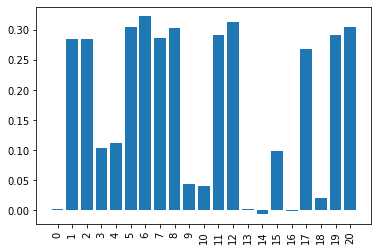

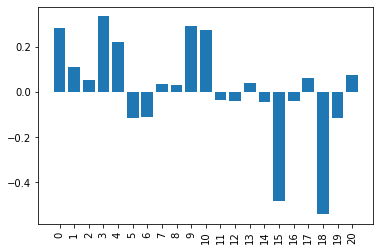

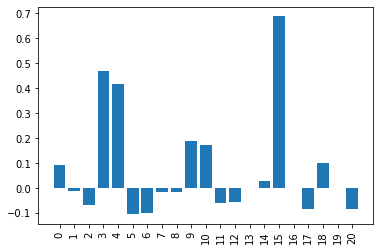

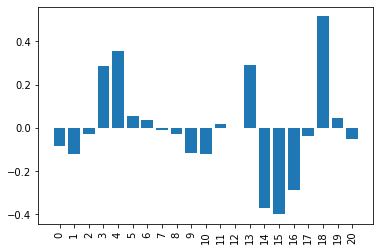

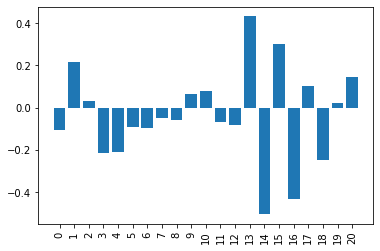

In [15]:
mealData = pd.read_csv('MealFeatures.csv')
noMealData = pd.read_csv('NoMealFeatures.csv')

GeneratePCA(mealData, PCA_filename)
mealTransform = Transform(mealData, PCA_filename)
noMealTransform = Transform(noMealData, PCA_filename)

In [16]:
mealLabels = np.ones((mealTransform.shape[0], 1))
noMealLabels = np.zeros((noMealTransform.shape[0], 1))

mealDataWithLabels = np.concatenate((mealTransform, mealLabels), axis=1)
noMealDataWithLabels = np.concatenate((noMealTransform, noMealLabels), axis=1)

dataset = np.concatenate((mealDataWithLabels, noMealDataWithLabels), axis=0)
np.random.shuffle(dataset)

# Training Model

## SVM

In [17]:
class Classifiers:
    def __init__(self):
        return
    
    def genClassifier1(self):
        self.Classifier1 = SVC(kernel='rbf', gamma='auto')
#         self.Classifier1 = NuSVC(nu=0.9, kernel='rbf', gamma='auto')
        
    def trainClassifier1(self, train_data):
        self.genClassifier1()
        self.Classifier1.fit(train_data[:, :-1], train_data[:, -1])
        
    def validateClassifier1(self, test_data):
        labels = self.Classifier1.predict(test_data[:, :-1])
        return labels
    
    def loadClassifier1(self, filename):
        return
        
    def saveClassifier1(self, filename):
        return

In [18]:
def evaluate(test_labels, labels):
    TP = 0.0
    FP = 0.0
    TN = 0.0
    FN = 0.0
    base = len(labels)
    for i in range(len(labels)):
        if labels[i] == 1:
            if test_labels[i] == 1:
                TP += 1
            else:
                FP += 1
        else:
            if test_labels[i] == 0:
                TN += 1
            else:
                FN += 1
    acc = (TP+TN)/base
    prec = (TP)/(TP+FP)
    rec = (TP)/(TP+FN)
    return acc, prec, rec

In [19]:
no_k = 5
kf = KFold(no_k)
total_acc = 0.0
total_prec = 0.0
total_rec = 0.0
models = Classifiers()
for train, test in kf.split(dataset):
    models.trainClassifier1(dataset[train])
    labels = models.validateClassifier1(dataset[test])
    acc, prec, rec = evaluate(dataset[test][:, -1], labels)
    total_acc += acc
    total_prec += prec
    total_rec += rec
    print("Acc = %f, Prec = %f, Rec = %f, F1 = %f" %(acc, prec, rec, 2*prec*rec/(prec+rec)))
print("MEAN: Acc = %f, Prec = %f, Rec = %f, F1 = %f" %(total_acc/no_k, total_prec/no_k, total_rec/no_k, 2*total_prec*total_rec/(no_k*(total_prec+total_rec))))

Acc = 0.708333, Prec = 0.688525, Rec = 0.823529, F1 = 0.750000
Acc = 0.666667, Prec = 0.652174, Rec = 0.652174, F1 = 0.652174
Acc = 0.604167, Prec = 0.536232, Rec = 0.860465, F1 = 0.660714
Acc = 0.687500, Prec = 0.735849, Rec = 0.709091, F1 = 0.722222
Acc = 0.663158, Prec = 0.660377, Rec = 0.714286, F1 = 0.686275
MEAN: Acc = 0.665965, Prec = 0.654631, Rec = 0.751909, F1 = 0.699906


## Gaussian Process Classifier (Vedant Salvi)

In [41]:
no_k = 10
kf = KFold(no_k)
total_acc = 0.0
total_prec = 0.0
total_rec = 0.0
gpc = None
test_data=None
#models = Classifiers()
for train, test in kf.split(dataset):
    kernel = 1.0 * RBF(1.0)
    gpc = GaussianProcessClassifier(kernel=kernel,random_state=0).fit(dataset[train][:, :-1], dataset[train][:, -1])
    gpc.score(dataset[train][:, :-1], dataset[train][:, -1])
    labels = gpc.predict(dataset[test][:, :-1])
    acc, prec, rec = evaluate(dataset[test][:, -1], labels)
    total_acc += acc
    total_prec += prec
    total_rec += rec
    test_data=dataset[test]
    print("Acc = %f, Prec = %f, Rec = %f, F1 = %f" %(acc, prec, rec, 2*prec*rec/(prec+rec)))
print("MEAN: Acc = %f, Prec = %f, Rec = %f, F1 = %f" %(total_acc/no_k, total_prec/no_k, total_rec/no_k, 2*total_prec*total_rec/(no_k*(total_prec+total_rec))))







Acc = 0.875000, Prec = 0.827586, Rec = 0.960000, F1 = 0.888889
Acc = 0.770833, Prec = 0.727273, Rec = 0.923077, F1 = 0.813559
Acc = 0.791667, Prec = 0.800000, Rec = 0.800000, F1 = 0.800000
Acc = 0.770833, Prec = 0.777778, Rec = 0.666667, F1 = 0.717949
Acc = 0.729167, Prec = 0.689655, Rec = 0.833333, F1 = 0.754717
Acc = 0.687500, Prec = 0.566667, Rec = 0.894737, F1 = 0.693878
Acc = 0.791667, Prec = 0.869565, Rec = 0.740741, F1 = 0.800000
Acc = 0.666667, Prec = 0.730769, Rec = 0.678571, F1 = 0.703704
Acc = 0.750000, Prec = 0.714286, Rec = 0.833333, F1 = 0.769231
Acc = 0.680851, Prec = 0.692308, Rec = 0.720000, F1 = 0.705882
MEAN: Acc = 0.751418, Prec = 0.739589, Rec = 0.805046, F1 = 0.770930


## Neural network - Multi-layer Perceptron (Vedant Salvi)

In [47]:
no_k = 5
kf = KFold(no_k)
total_acc = 0.0
total_prec = 0.0
total_rec = 0.0
#models = Classifiers()
for train, test in kf.split(dataset):
    clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(4, 2), random_state=1)
    clf.fit(dataset[train][:, :-1], dataset[train][:, -1])
    labels = clf.predict(dataset[test][:, :-1])
    acc, prec, rec = evaluate(dataset[test][:, -1], labels)
    total_acc += acc
    total_prec += prec
    total_rec += rec
    test_data=dataset[test]
    print("Acc = %f, Prec = %f, Rec = %f, F1 = %f" %(acc, prec, rec, 2*prec*rec/(prec+rec)))
print("MEAN: Acc = %f, Prec = %f, Rec = %f, F1 = %f" %(total_acc/no_k, total_prec/no_k, total_rec/no_k, 2*total_prec*total_rec/(no_k*(total_prec+total_rec))))


Acc = 0.760417, Prec = 0.689189, Rec = 1.000000, F1 = 0.816000
Acc = 0.812500, Prec = 0.750000, Rec = 0.913043, F1 = 0.823529
Acc = 0.750000, Prec = 0.666667, Rec = 0.883721, F1 = 0.760000
Acc = 0.760417, Prec = 0.728571, Rec = 0.927273, F1 = 0.816000
Acc = 0.726316, Prec = 0.688525, Rec = 0.857143, F1 = 0.763636
MEAN: Acc = 0.761930, Prec = 0.704590, Rec = 0.916236, F1 = 0.796595


## Code to Save model

In [42]:
joblib.dump(gpc, 'gpc.pkl') 
gpc_from_joblib = joblib.load('gpc.pkl')  
gpc_from_joblib.predict(dataset[train][:, :-1]) 
acc, prec, rec = evaluate(dataset[test][:, -1], labels)
total_acc += acc
total_prec += prec
total_rec += rec
test_data=dataset[test]
print("Acc = %f, Prec = %f, Rec = %f, F1 = %f" %(acc, prec, rec, 2*prec*rec/(prec+rec)))
print("MEAN: Acc = %f, Prec = %f, Rec = %f, F1 = %f" %(total_acc/no_k, total_prec/no_k, total_rec/no_k, 2*total_prec*total_rec/(no_k*(total_prec+total_rec))))


Acc = 0.680851, Prec = 0.692308, Rec = 0.720000, F1 = 0.705882
MEAN: Acc = 0.819504, Prec = 0.808819, Rec = 0.877046, F1 = 0.841552
